In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define VGGNet architecture
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Synthetic dataset generation
def generate_data(num_samples=1000, image_size=64):
    X = np.random.randint(0, 256, (num_samples, image_size, image_size, 3), dtype=np.uint8)
    y = np.random.randint(0, 2, num_samples)
    return X, y

# Data preprocessing
def preprocess_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y = torch.tensor(y, dtype=torch.long)
    return X, y

# Visualization: t-SNE
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embedded = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    for cls in np.unique(labels):
        plt.scatter(embedded[labels == cls, 0], embedded[labels == cls, 1], label=f'Class {cls}')
    plt.title('t-SNE Visualization of Feature Embeddings')
    plt.legend()
    plt.show()

# Main code
if __name__ == "__main__":
    # Generate synthetic data
    X_train, y_train = generate_data(num_samples=1000)
    X_test, y_test = generate_data(num_samples=200)

    # Preprocess data
    X_train, y_train = preprocess_data(X_train, y_train)
    X_test, y_test = preprocess_data(X_test, y_test)

    # Instantiate the model
    model = VGGNet(num_classes=2)

    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluation
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        print(f'Accuracy on test set: {accuracy:.4f}')



Epoch [1/10], Loss: 0.6931
Epoch [2/10], Loss: 0.8729
Epoch [3/10], Loss: 0.9410
Epoch [4/10], Loss: 0.7098
Epoch [5/10], Loss: 0.6936
Epoch [6/10], Loss: 0.6929
Epoch [7/10], Loss: 0.6928
Epoch [8/10], Loss: 0.6928
Epoch [9/10], Loss: 0.6929
Epoch [10/10], Loss: 0.6925
Accuracy on test set: 0.4700


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

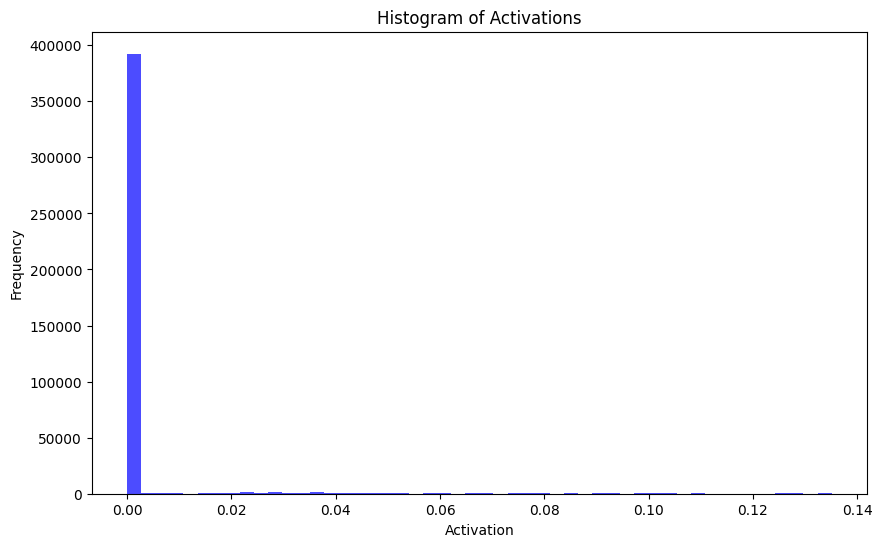

In [26]:
    # 1. Histogram of Activations
    activations = model.features(X_test).detach().reshape(X_test.shape[0], -1).cpu().numpy()
    plt.figure(figsize=(10, 6))
    plt.hist(activations.flatten(), bins=50, alpha=0.7, color='b')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.title('Histogram of Activations')
    plt.show()

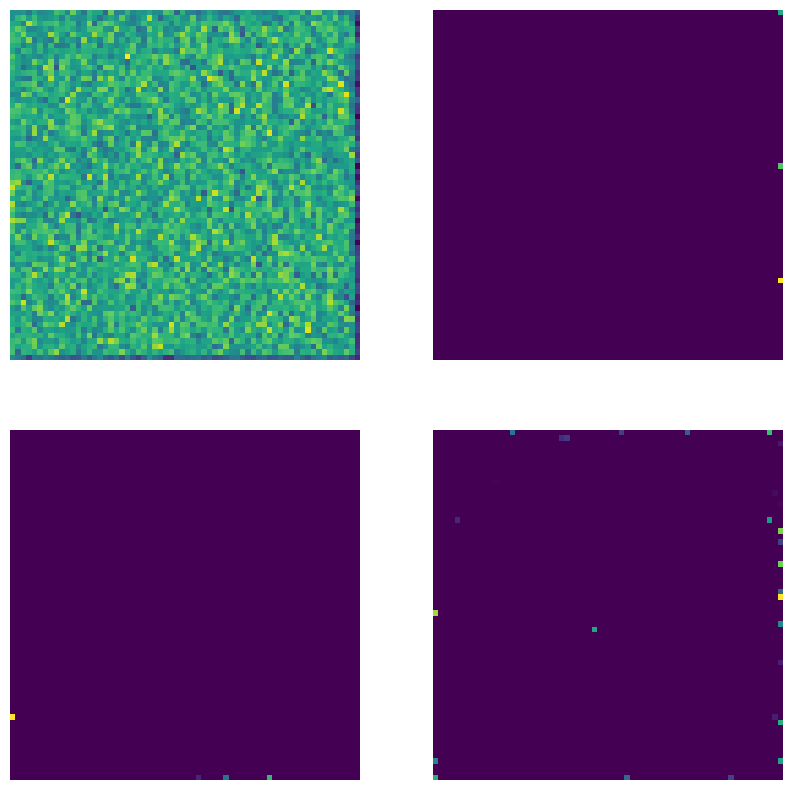

In [27]:
    # 2. Feature Map Visualization
    activations = model.features[:4](X_test[0].unsqueeze(0))
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(2):
        for j in range(2):
            axs[i, j].imshow(activations[0, i * 2 + j].detach().cpu().numpy(), cmap='viridis')
            axs[i, j].axis('off')
    plt.show()

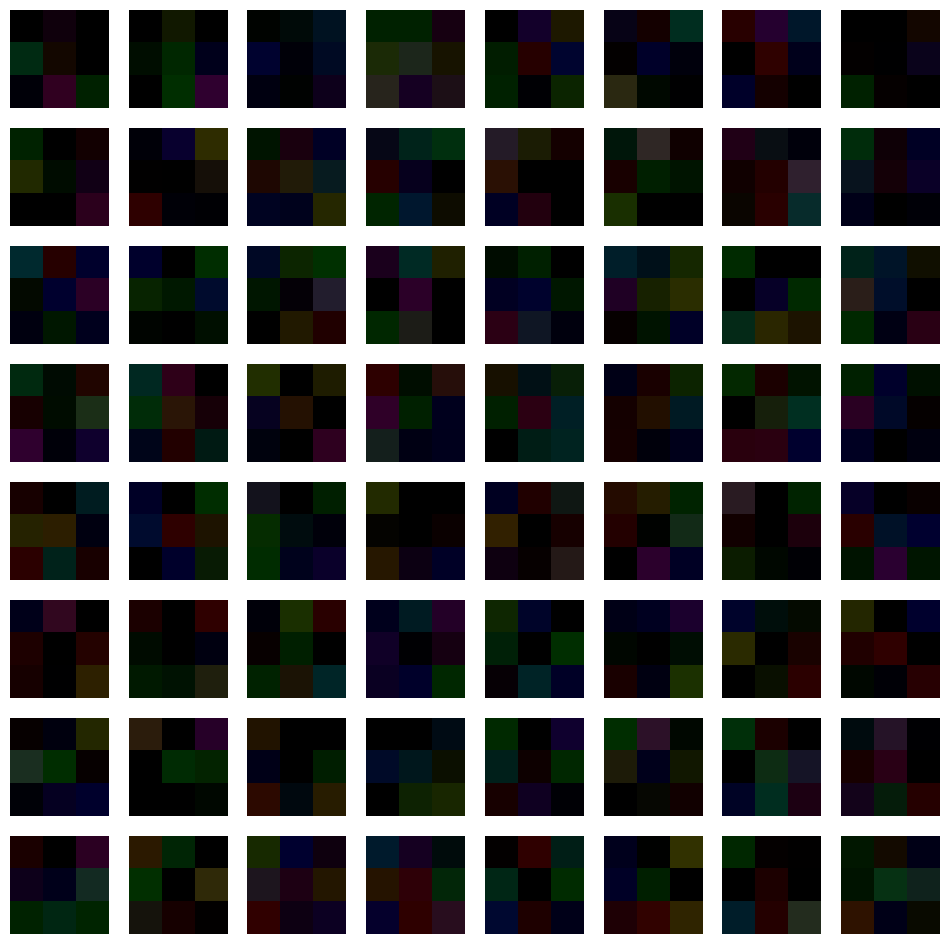

In [28]:
    # 3. Weights Visualization
    filters = model.features[0].weight.data.cpu().numpy()
    fig, axs = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            axs[i, j].imshow(filters[i * 8 + j].transpose(1, 2, 0))
            axs[i, j].axis('off')
    plt.show()

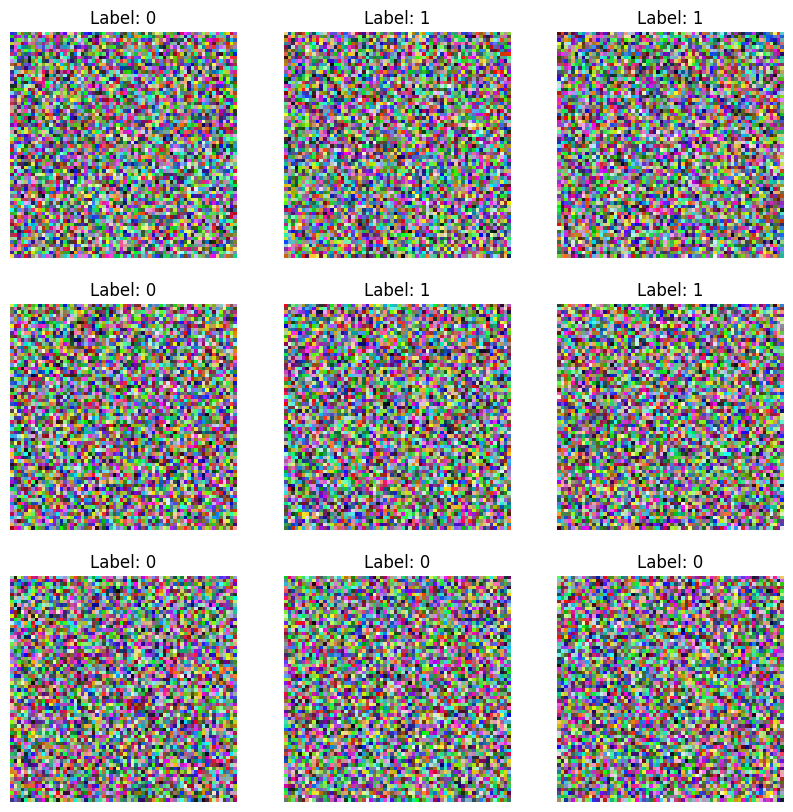

In [31]:
# Visualization: Sample Images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].permute(1, 2, 0))
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')
plt.show()
